# Необходимые модули 

In [1]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K
from PIL import Image, ImageDraw, ImageFont
import string
import random

%matplotlib inline

2023-06-01 20:59:21.825171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 20:59:22.174230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 20:59:22.175790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 20:59:24.400075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT




# Функции для изменения изображений 
1) шум
2) блюр
3) вращение
4) затемнение
5) разное расстояние между символами
6) разное соотношение сторон

In [2]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [3]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [4]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [5]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## Preparing Dataset

Ниже представлены методы для создания датасета. Используются два шрифта Arial и Times New Roman. Создаётся строка из случайных символов (буквы и цифры), далее создаётся картинка с этой строкой. Возможно создать датасет любого размера. Легко добавить новые шрифты.

In [7]:
## Functions for generating dataset (images containing couple of random characters in desired font)

def string_gen(size=6, chars=string.ascii_uppercase + string.digits + string.ascii_lowercase):
    """
    generates string containing random characters (letters & numbers)
    """
    return ''.join(random.choice(chars) for _ in range(size))

def img_gen(font_name, string):
    """
    generates an image with desired font and string
    """
    img = Image.new('RGB', (105,105), color = (255, 255, 255))
    font = ImageFont.truetype(f'fonts/{font_name}.ttf', 80)
    d = ImageDraw.Draw(img)
    d.text((10,10), string, font=font, fill=(0, 0, 0))
    img.save(f'font_imgs/{font_name}/{string}.jpg')

def gen_dataset(fonts, amount = 10):
    """
    Used to create large dataset of images with random strings for any amount of fonts we need
    """
    amount = amount * len(fonts)
    while amount != 0:
        for font in fonts:
            img_gen(font, string_gen())
            amount -= 1
    print('samples are ready!')

def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

In [8]:
## generating dataset for 2 fonts 100 samples each and making shuffled image paths for further splitting
fonts = ['times_new_roman', 'arial']
# os.mkdir('fonts/')
# os.mkdir('font_imgs/')
# for font in fonts:
#   os.mkdir(f'font_imgs/{font}/')
gen_dataset(fonts, 100)

data_path = "font_imgs/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

samples are ready!


In [9]:
## Functions for labelling and reversed labelling

def conv_label(label):
    if label == 'arial':
        return 0
    elif label == 'times_new_roman':
        return 1

def rev_conv_label(label):
    if label == 0 :
        return 'Arial'
    elif label == 1:
        return 'Times New Roman'



In [11]:
augument=["noise","affine","gradient"]
a=itertools.combinations(augument, 3)

for i in list(a): 
    print(list(i))

['noise', 'affine', 'gradient']


Изменим картинки в датасете с помощью эффектов, подобранных случайным образом из списка эффектов. Это поможет лучше натренировать модель.

In [12]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
            # print(len(combinations))
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)
                    
    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

Разобьём датасет на тренировочную и тестовую части

In [ ]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# 75 - тренировка
# 25 - тест
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Success


In [ ]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [ ]:
K.set_image_data_format('channels_last')


Создадим модель из блоков Keras. Архитектура модели предложена Adobe, Google и называется DeepFont. С помощью этой архитектуры можно различать больше двух тысяч шрифтов, главное - обучить. 


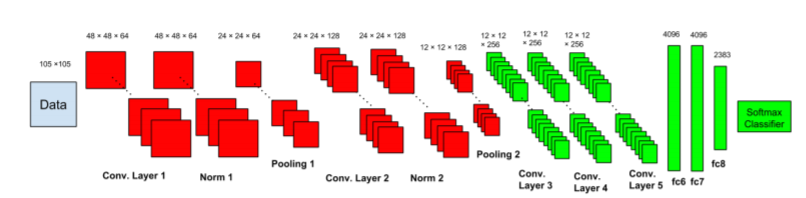

В отличие от других сверточных нейронных сетей для классификации изображений, эта организована иначе. Она состоит из двух подсетей:

* **Подсеть низкого уровня**: Обучается на основе комбинированного набора синтетических и реальных данных.
* **Подсеть высокого уровня** : Обучает глубокий классификатор на основе низкоуровневых характеристик.
  Для получения более подробной информации и разъяснений: (https://arxiv.org/pdf/1507.03196v1.pdf)

In [13]:
def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(4096,activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(2383,activation='relu'))

  model.add(Dense(2, activation='softmax'))
 
  return model

In [ ]:
batch_size = 128
epochs = 50
model= create_model()
sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [ ]:
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

training process is taking a lot of time, so we will use the model which is pretrained already.

In [15]:
from keras.models import load_model
model = load_model('top_model.h5')

2023-06-01 21:00:48.369027: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2023-06-01 21:00:48.380815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2023-06-01 21:00:48.388228: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2023-06-01 21:00:48.461644: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2023-06-01 21:00:48.488840: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


In [1]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'model' is not defined

Время тестов! введите название шрифта в `test_font`, и пример текста в `test_text`.

1/1 [==============================] - 0s 53ms/step


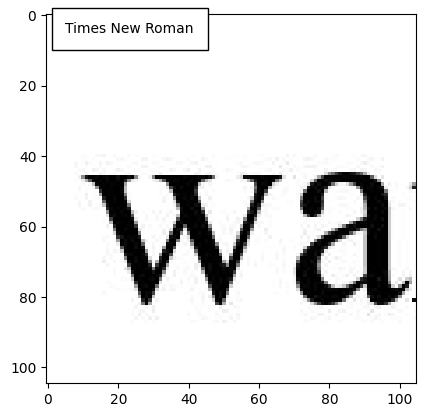

In [ ]:
test_font = 'times_new_roman'
test_text = 'wanna play'

img_gen(test_font, test_text)
img_path=f"font_imgs/{test_font}/{test_text}.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
# pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)
# plt.imshow(org_img, cmap='gray');

data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0
y = model.predict(data)
pred = y[0].argmax()

label = rev_conv_label(y[0].argmax())
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()



In [ ]:
y

array([[3.5716255e-06, 9.9999642e-01]], dtype=float32)